# imports

In [19]:
%run read_matlab_file.ipynb
%run LC_calibration.ipynb

All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
All MAC paths are set!
read_matlab_file.ipynb loaded successfully!
convert_erg.ipynb loaded successfully!
safety_time.ipynb loaded successfully!
LC_calibration loaded successfully!


# XPEC data preperation

### TODO
    - Extract the bins from the txt file. DONE
    
    - Bin the keV into the predefined bins. DONE
    
    - Implement function for T0 & tus correction (ToF). DONE
        --> COMMENT: still 300ms error after calibrating GRB190206
        
    -Do all the steps above for GRB200415A and cross check results. DONE
    
    - Implement function for cutting the tus & keV array at time interval given by Anastasia or GCN report 
        ---> NEXT UP
 
    - make sure the T0 are correctly clibrated. Send complete list to Andrey for validation
    
    
### Notes
    -Assuming 
    -bins_keV are the right most edges! 
    -Anders have filtered for keV >=500 
    -Implementation is ok. Proceed to wrapping a function around it.
    --> have a shift variable as input (have to do with lining up the LC from the different spacecrafts)
    
    
### Problems
    -GRB200415: Problem lining up the T0 from my data to the data that Anders used to histogram the data for 0.8ms <=tus <= 3.2ms
    Since the data is shifted a small amount the number of counts in the bins don't match up correctly.
    --> Absolute time correction is neccecary, but this value might be different from the one Anders used.
    -->Error of 4151.099 ... us (4.1 ms) from df_A and my df.
 
    
    -GRB200415: The binning does not produce the same bin counts in Ander´s df_A and the df_check
    --> Because of filtering for keV's >= 500
    
    

In [2]:
#time of flight from KW to ASIM. Given in seconds
ToF = {"GRB180720":-4.2377,"GRB181222":2.8716, "GRB190206":4.9225, "GRB190305":3.4460,
      "GRB190606":4.0316,"GRB200415":4.1840,"GRB200521":-0.6226,"GRB200716":3.0155,
      "GRB201227":0.7142, "GRB210424":-0.5033, "GRB210619":-2.6183}

In [3]:
def ToF_correction(grb_id=None):
    ToF_us = ToF[grb_id]*1e6
    df,T0 = complete_df(grb_id=grb_id)
    df["tus"], T0_calibrated = df["tus"] - ToF_us, T0 - timedelta(microseconds=ToF_us) #calibrating 
    return df,T0,T0_calibrated

# bin control

In [4]:
df_bin = pd.read_csv("/Users/andreas/phys/master/GRB/spectral_analysis/HED_binedges.txt")
df_bin.head()

,energy_bin_start_keV,energy_bin_stop_keV
0,10.00000,12.58925
1,12.58925,15.84893
2,15.84893,19.95262
3,19.95262,25.11886
4,25.11886,31.62278


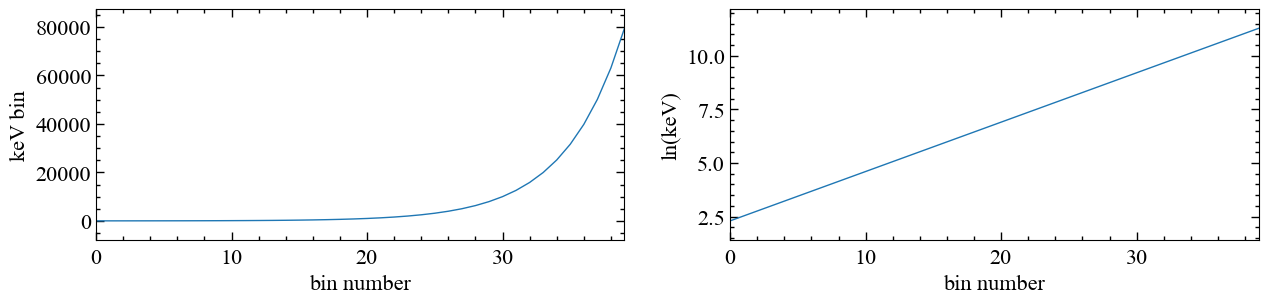

In [5]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,3))

ax1.plot((df_bin["energy_bin_start_keV"]))
ax2.plot(np.log(df_bin["energy_bin_start_keV"]))
ax1.set_xlabel("bin number")
ax1.set_ylabel("keV bin")
ax2.set_xlabel("bin number")
ax2.set_ylabel("ln(keV)")
plt.show()

In [6]:
start = df_bin["energy_bin_start_keV"].to_numpy()
#start = np.append(0,start)
end = df_bin["energy_bin_stop_keV"].to_numpy()
bins_keV=np.append(start,end[-1])
print(len(bins_keV))
bins_keV

41


array([1.000000e+01, 1.258925e+01, 1.584893e+01, 1.995262e+01,
       2.511886e+01, 3.162278e+01, 3.981072e+01, 5.011872e+01,
       6.309573e+01, 7.943282e+01, 1.000000e+02, 1.258925e+02,
       1.584893e+02, 1.995262e+02, 2.511886e+02, 3.162278e+02,
       3.981072e+02, 5.011872e+02, 6.309573e+02, 7.943282e+02,
       1.000000e+03, 1.258925e+03, 1.584893e+03, 1.995262e+03,
       2.511886e+03, 3.162278e+03, 3.981072e+03, 5.011872e+03,
       6.309573e+03, 7.943282e+03, 1.000000e+04, 1.258925e+04,
       1.584893e+04, 1.995262e+04, 2.511886e+04, 3.162278e+04,
       3.981072e+04, 5.011872e+04, 6.309573e+04, 7.943282e+04,
       1.000000e+05])

In [7]:
df_hist_check = pd.read_csv("/Users/andreas/phys/master/GRB/spectral_analysis/HED_(0.8 ms to 3.2 ms).txt")
print("Num hist counts totoal: ", sum(df_hist_check["counts"].to_numpy()[1:]))
print("bins_keV are the right most edge")

df_hist_check.head()

Num hist counts totoal:  300.0
bins_keV are the right most edge


,bins_keV,counts,poisson_error_counts,duration_seconds
0,10.00000,-9999.0,-9999.0,-9999.0000
1,12.58925,0.0,0.0,0.0024
2,15.84893,0.0,0.0,0.0024
3,19.95262,0.0,0.0,0.0024
4,25.11886,0.0,0.0,0.0024


# keV bin function

In [103]:
def keV_hist(df=None,time_interval=None,keV_interval=None,keV_bins=None,duration=None):
    '''
    NOTE: working with ms resolution for the tus array
    
    input: df <pd.dataframe> complete dataframe with no flagged events
    time_interval <tuple> start and end (ms) of the time interval for the keV binning.
    keV_interval <tuple> default is None. Meaning the whole spectrum
    duration <float> defaul is None. Must be provided in ms 
    
    return: <pd.dataframe> with the bin_counts and bin_edges as a dataframe
    '''
    df.sort_values(by=['tus'],inplace=True) #first sorting by tus in increasing order
    
    
    #tus handling-------------------------------------------
    tus_arr = df["tus"].to_numpy()
    tus_arr = tus_arr/1e3 #converting to ms resolution

    
    if time_interval==None:
        tus_start,tus_end = min(tus_arr),max(tus_arr)
        idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the last trigger
    else:
        tus_start,tus_end = time_interval[0],time_interval[1] #selecting the interval
        idx_start, idx_end = find_nearest(tus_arr,tus_start), find_nearest(tus_arr,tus_end)+1 #including the nearest trigger

    tus_arr = tus_arr[idx_start:idx_end] #selecting the interval for tus
    
    #keV handling-------------------------------------------
    keV_arr = df["keV"].to_numpy()
    keV_arr = keV_arr[idx_start:idx_end] #selecting keV's on the given tus interval
    
    if keV_interval==None:
         keV_lower,keV_upper = 0,1e16 #selecting artificially high bounds
    else: 
        keV_lower,keV_upper = keV_interval[0],keV_interval[1] #selecting the bounds for the keV's

    ii = []
    for i,keV in enumerate(keV_arr): #finding
        if keV_lower<=keV<=keV_upper:
            ii.append(i)
            
    tus_keV_bound = tus_arr[ii]
    keV_bound = keV_arr[ii]
    
    #histogramming-----------------------------------------
    hist_keV,edges_keV = np.histogram(keV_bound,bins=keV_bins)
    
    poisson_arr = np.sqrt(hist_keV) #handle this one. might be some negative numbers in it?
    if hist_keV[0] == 0:
        hist_keV = np.append(-9999.0,hist_keV)
        poisson_arr = np.append(-9999.0,poisson_arr)
    duration_arr = np.append(-9999.0,(([duration/1e3])*(len(hist_keV)-1)))
    df_keV = pd.DataFrame({"bins_keV":edges_keV, "counts":hist_keV, 
                           "poisson_error_counts":poisson_arr, "duration_seconds":duration_arr}) #ERROR different lengths!
    print("Energies binned!")
    return df_keV

In [77]:
duration_arr = np.append(-9999.0,np.array([64]*(41-1)))
duration_arr

array([-9999.,    64.,    64.,    64.,    64.,    64.,    64.,    64.,
          64.,    64.,    64.,    64.,    64.,    64.,    64.,    64.,
          64.,    64.,    64.,    64.,    64.,    64.,    64.,    64.,
          64.,    64.,    64.,    64.,    64.,    64.,    64.,    64.,
          64.,    64.,    64.,    64.,    64.,    64.,    64.,    64.,
          64.])

# Exporting all keV histograms

In [116]:
df,T0 = complete_df(grb_id="GRB190206",remove_flag=True)
df.sort_values(by=['tus'],inplace=True)
tus = df["tus"].to_numpy()
len(tus)

Creating df for short GRB
Absolute time correction subtracted from T0
187 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 287 flags
Removed 287 flags from df


24300

In [63]:
start,end = find_nearest(tus/1e3,297),find_nearest(tus/1e3,361)
start,end

(10972, 13835)

In [64]:
start_bg,end_bg = find_nearest(tus/1e3,-500),find_nearest(tus/1e3,200)
start_bg,end_bg

(2258, 9841)

In [100]:
pd.set_option('display.float_format', '{:.6E}'.format)

In [104]:
df_keV = keV_hist(df=df,time_interval=(297.0,361.0),keV_bins=bins_keV,duration=64.0)

Energies binned!


In [117]:
df_keV_bg = keV_hist(df=df,time_interval=(-600.0,200.0),keV_bins=bins_keV,duration=64.0)

Energies binned!


In [115]:
np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_histogram.txt"',df_keV.values, delimiter=',', 
           header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

In [119]:
np.savetxt(r'/Users/andreas/phys/master/GRB/spectral_analysis/GRB190206A_keV_hist_background (-600 ms to 200 ms).txt"',df_keV_bg.values, delimiter=',', 
           header='bins_keV,counts,poisson_error_counts,duration_seconds', fmt='%.6E')

In [120]:
plt.hist(df["keV"].to_numpy()[start])

,bins_keV,counts,poisson_error_counts,duration_seconds
0,1.000000E+01,-9.999000E+03,-9.999000E+03,-9.999000E+03
1,1.258925E+01,0.000000E+00,0.000000E+00,6.400000E-02
2,1.584893E+01,0.000000E+00,0.000000E+00,6.400000E-02
3,1.995262E+01,0.000000E+00,0.000000E+00,6.400000E-02
4,2.511886E+01,0.000000E+00,0.000000E+00,6.400000E-02
5,3.162278E+01,0.000000E+00,0.000000E+00,6.400000E-02
6,3.981072E+01,0.000000E+00,0.000000E+00,6.400000E-02
7,5.011872E+01,0.000000E+00,0.000000E+00,6.400000E-02
8,6.309573E+01,0.000000E+00,0.000000E+00,6.400000E-02
9,7.943282E+01,0.000000E+00,0.000000E+00,6.400000E-02


tus array OK ...


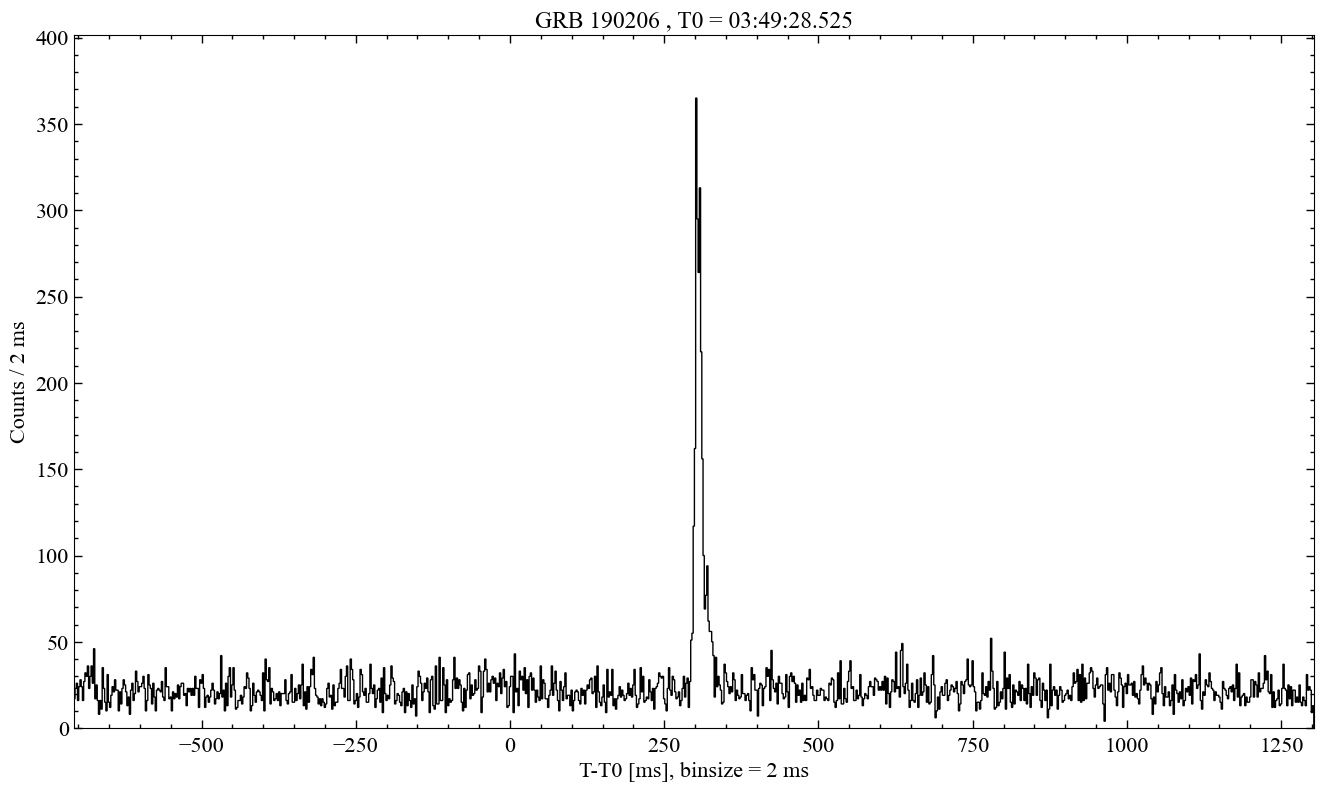

In [58]:
plot_HED(tus_arr=tus,T0=T0,binsize=2)

tus array OK ...


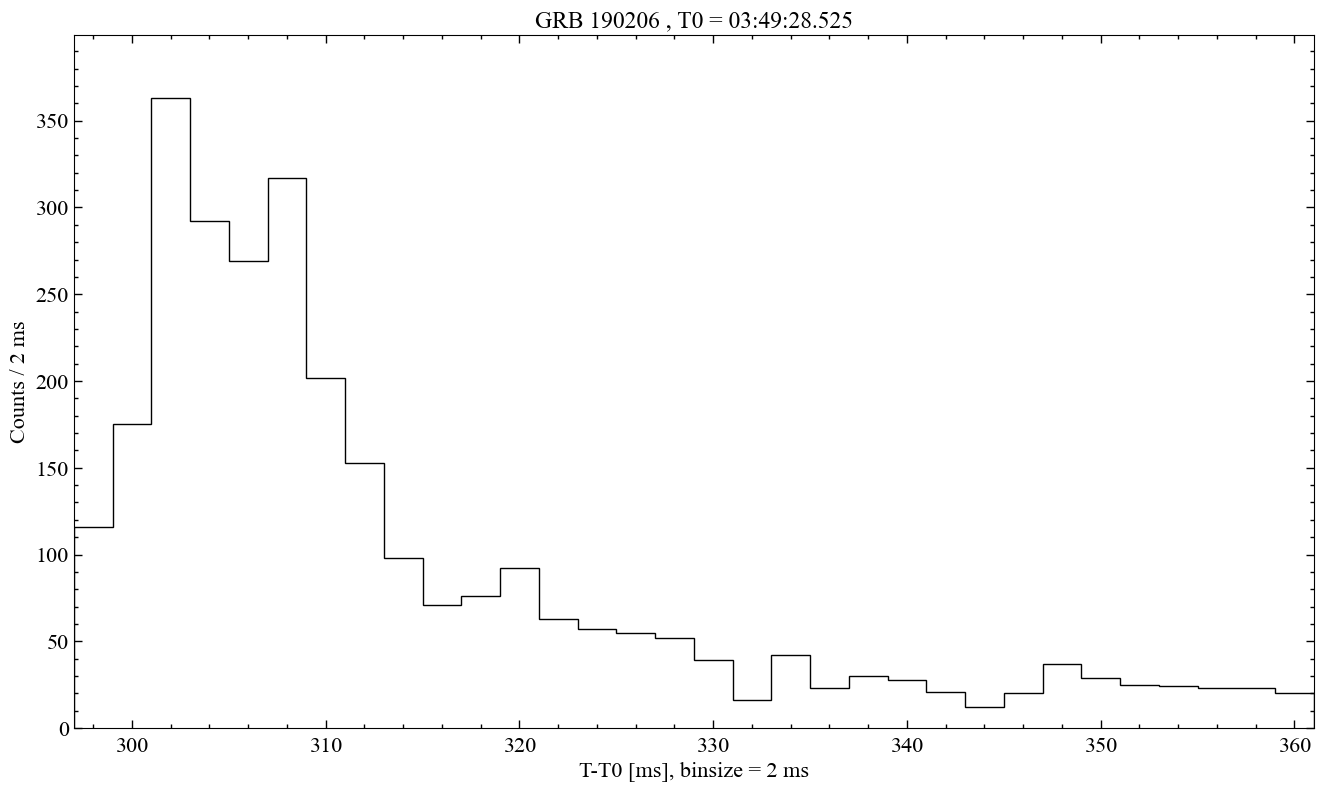

In [57]:
plot_HED(tus_arr=tus[start:end],T0=T0,binsize=2)

In [ ]:
# export keV histogram for GRB190206A in the same format as example by Anders, Duration is 64 ms 
# lag = -27.


#build spectra for main event on this interval
time_interval = 297,297+64 #ms


#interval for background:
bg_interval = -0.9,-0.2


In [21]:
for grb_id in selected_grb_id:
    df,T0 = complete_df(grb_id=grb_id,remove_flag=True,flag_cut="HED")
    df_keV = keV_hist(df=df,keV_bins=bins_keV)
    print("Exporting csv")
    df_keV.to_csv(path_keV_hist + grb_id,index=False)

Creating df for long GRB
Absolute time correction subtracted from T0
37 valleys removed
Absolute time correction subtracted from T0
29 valleys removed
Absolute time correction subtracted from T0
23 valleys removed
Absolute time correction subtracted from T0
27 valleys removed
Absolute time correction subtracted from T0
21 valleys removed
subseq not found in next array ... keeping whole array
subseq not found in next array ... keeping whole array
found one cutting index ... 
subseq not found in next array ... keeping whole array
GRB concatenated ...
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 256 flags
Removed 256 flags from df
Energies binned!
Exporting csv
Creating df for short GRB
Absolute time correction subtracted from T0
197 valleys removed
erg converted to keV
df sorted by adr and tus
safety time events flagged. Found 326 flags
Removed 326 flags from df
Energies binned!
Exporting csv
Creating df for short GRB
Absolute time correction subtracted

In [17]:
bins_keV


array([1.000000e+01, 1.258925e+01, 1.584893e+01, 1.995262e+01,
       2.511886e+01, 3.162278e+01, 3.981072e+01, 5.011872e+01,
       6.309573e+01, 7.943282e+01, 1.000000e+02, 1.258925e+02,
       1.584893e+02, 1.995262e+02, 2.511886e+02, 3.162278e+02,
       3.981072e+02, 5.011872e+02, 6.309573e+02, 7.943282e+02,
       1.000000e+03, 1.258925e+03, 1.584893e+03, 1.995262e+03,
       2.511886e+03, 3.162278e+03, 3.981072e+03, 5.011872e+03,
       6.309573e+03, 7.943282e+03, 1.000000e+04, 1.258925e+04,
       1.584893e+04, 1.995262e+04, 2.511886e+04, 3.162278e+04,
       3.981072e+04, 5.011872e+04, 6.309573e+04, 7.943282e+04,
       1.000000e+05])

from astropy.table import Table
df = pd.read_csv("/Users/andreas/phys/master/GRB/spectral_analysis/keV_histograms/GRB180720")
t = Table.from_pandas(df)
t.write('GRB180720_new.fits')